In [77]:
import numpy as np 
import scipy.stats as ss 
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

### Assumptions

- Model 2 is always the extended model.

In [2]:
param1 = [-1.0, 4.0]
param2 = [4.0, 0.75] # [-1.0, 4.0, 0.1] # [-1.0, 4.0] # 
nparam1 = len(param1)
nparam2 = len(param2)
priorwidth = 10.0
priorcov1 = np.eye(nparam1) * priorwidth
priorcov2 = np.eye(nparam2) * priorwidth

minx = 0.0 
maxx = np.pi 
ndata = 100
domain = np.linspace(minx, maxx, ndata)
grad1 =  np.vstack([domain**2, domain]).T
# grad2 = np.vstack([domain**3, domain, np.ones(ndata)]).T # 

gradient_param_0 = np.sin(param2[1] * domain)
gradient_param_1 = param2[0] * domain * np.cos(param2[1] * domain)
grad2 = np.vstack([gradient_param_0, gradient_param_1]).T
        
sigma = 0.2
noise_cov = np.diag(np.ones(ndata)*sigma**2)

In [3]:
def model_1(param, domain):
    return param[0]*domain**2 + param[1]*domain

def model_2(param, domain):
    return param[0] * np.sin(param[1]*domain) # param[0]*domain**3 + param[1]*domain #    + param[2]

In [56]:
mu_fid_1 = model_1(param1, domain)
mu_fid_2 = model_2(param2, domain)
data = mu_fid_1 + sigma*np.random.randn(ndata)
X1 = data - mu_fid_1

### Full Data

In [57]:
covdata1 = noise_cov + grad1 @ priorcov1 @ grad1.T
covdata2 = noise_cov + grad2 @ priorcov2 @ grad2.T

In [58]:
evi1 = ss.multivariate_normal(np.zeros(ndata), covdata1)
evi2 = ss.multivariate_normal(np.zeros(ndata), covdata2)

In [59]:
evi1.logpdf(X1)

22.083473873034514

In [60]:
evi2.logpdf(X1)

21.804515056623508

In [61]:
evi1.logpdf(X1) - evi2.logpdf(X1)

0.27895881641100573

### Compression

In [62]:
b1_mat = np.linalg.inv(noise_cov) @ grad1
b2_mat = np.linalg.inv(noise_cov) @ grad2

In [63]:
lambda_1 = b1_mat.T @ noise_cov @ b1_mat
lambda_2 = b2_mat.T @ noise_cov @ b2_mat

In [64]:
cov_comp_2 = lambda_2 + lambda_2 @ priorcov2 @ lambda_2

# modified covariance for first model 
wmat = grad2.T @ np.linalg.inv(noise_cov) @ grad1
cov_comp_1 = lambda_2 + wmat @ priorcov1 @ wmat.T

In [65]:
ycomp = b2_mat.T @ X1

In [66]:
comp_evi1 = ss.multivariate_normal(np.zeros(nparam2), cov_comp_1)
comp_evi2 = ss.multivariate_normal(np.zeros(nparam2), cov_comp_2)

In [67]:
comp_evi1.logpdf(ycomp)

-21.445278799889596

In [68]:
comp_evi2.logpdf(ycomp)

-21.69792408356197

In [69]:
comp_evi1.logpdf(ycomp) - comp_evi2.logpdf(ycomp)

0.25264528367237205

# Repetitions

In [70]:
record_full = list()
record_comp = list()
ntrials = 5000

for i in range(ntrials):
    data = mu_fid_1 + sigma*np.random.randn(ndata)
    X1 = data - mu_fid_1
    ycomp = b2_mat.T @ X1
    record_full.append(evi1.logpdf(X1) - evi2.logpdf(X1))
    record_comp.append(comp_evi1.logpdf(ycomp) - comp_evi2.logpdf(ycomp))

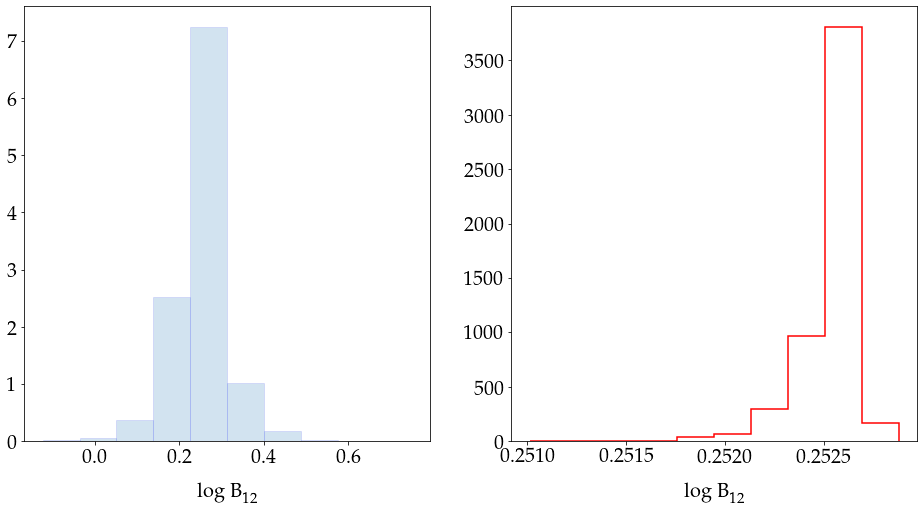

In [79]:
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.hist(record_full, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.hist(record_comp, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

In [72]:
np.mean(record_full), np.std(record_full)

(0.2508006167180772, 0.06280558287093481)

In [73]:
np.mean(record_comp), np.std(record_comp)

(0.25253860582771903, 0.00014376767156397047)